Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda with 36 transformer layers.
[INFO] Loaded 5 prompts.


Prompts: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] Computed Fisher Information for 36 layers.
[INFO] Saved Fisher Information → fisher/fisher_information.json


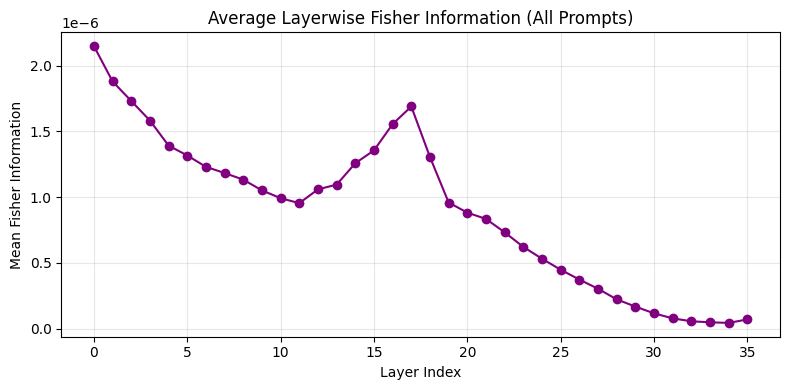

/home/rameyjm7/workspace/TML/Project_1/lighteval_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rameyjm7/workspace/TML/Project_1/lighteval_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[RESULT] Fisher–Saliency correlation (layerwise): r = nan


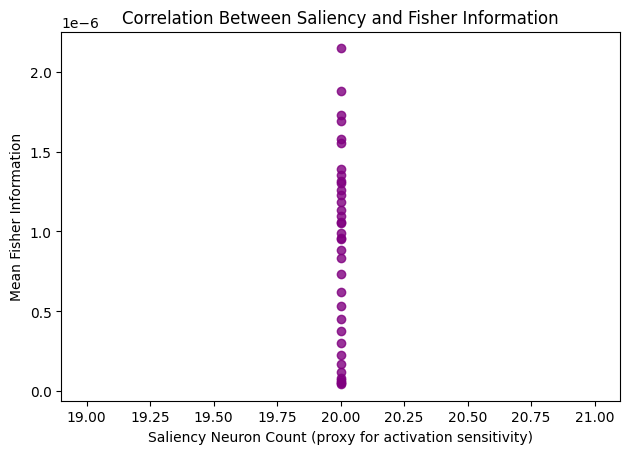

[INFO] Saved top-25 Fisher neurons → fisher/top_fisher_neurons.json


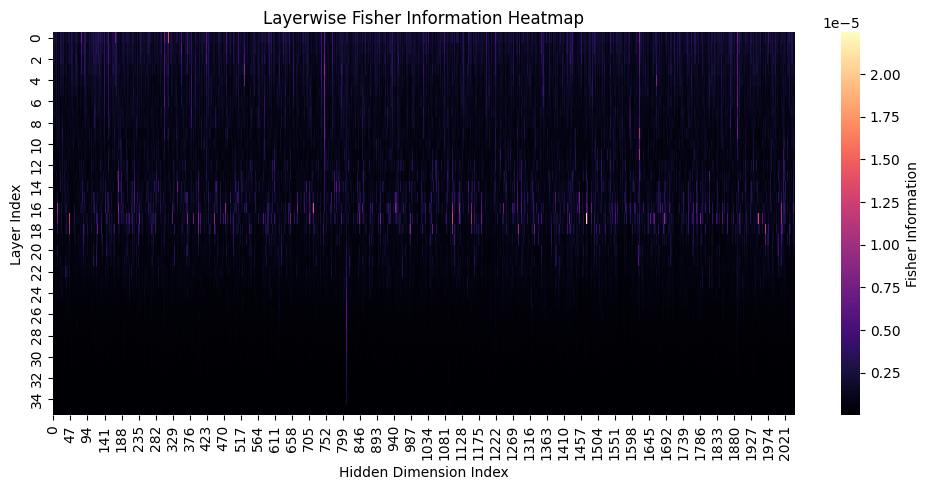

In [2]:
#!/usr/bin/env python3
"""
Phase 4.2 — Fisher Information Analysis
Computes per-layer Fisher Information for Qwen2.5-3B-Instruct,
correlates it with saliency, and exports top Fisher neurons.
"""

import os, json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
LOG_DIR = "logs"
SAVE_DIR = "fisher"
SALIENCY_FILE = "sensitive_neurons.json"
TOP_K = 25  # number of top neurons to save per layer
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------------------------------------
# 2. Load model
# ---------------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()
n_layers = len(model.model.layers)
print(f"[INFO] Loaded {MODEL_NAME} on {device} with {n_layers} transformer layers.")

# ---------------------------------------------------------------------
# 3. Load latest prompt set
# ---------------------------------------------------------------------
log_files = sorted(
    [f for f in os.listdir(LOG_DIR) if f.startswith("recommender_") and f.endswith(".json")]
)
if not log_files:
    raise FileNotFoundError("No recommender_*.json logs found.")
latest_log = os.path.join(LOG_DIR, log_files[-1])

with open(latest_log, "r", encoding="utf-8") as f:
    data = json.load(f)
prompts = [r["question"] for r in data["records"]]
print(f"[INFO] Loaded {len(prompts)} prompts.")

# ---------------------------------------------------------------------
# 4. Register hooks to retain gradients for Fisher
# ---------------------------------------------------------------------
store = {}
def fisher_hook(module, inp, out, layer_idx):
    """Attach hook that retains gradients for hidden states."""
    if isinstance(out, tuple):
        out = out[0]
    out.retain_grad()
    store[layer_idx] = out

handles = []
for idx, layer in enumerate(model.model.layers):
    h = layer.register_forward_hook(lambda m, i, o, idx=idx: fisher_hook(m, i, o, idx))
    handles.append(h)

# ---------------------------------------------------------------------
# 5. Compute Fisher Information
# ---------------------------------------------------------------------
def compute_fisher(model, tokenizer, prompts):
    fisher_scores = {f"layer_{l}": [] for l in range(n_layers)}

    for prompt in tqdm(prompts, desc="Prompts"):
        store.clear()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        loss.backward(retain_graph=False)

        # Collect per-layer Fisher ≈ E[(∂log p / ∂h)^2]
        for l_idx, acts in store.items():
            if acts.grad is None:
                continue
            grad_sq = acts.grad.detach().float().pow(2).mean(dim=1).squeeze(0).cpu().numpy()
            if grad_sq.ndim > 0:
                fisher_scores[f"layer_{l_idx}"].append(grad_sq)

        model.zero_grad(set_to_none=True)

    fisher_means = {}
    for l, vals in fisher_scores.items():
        if vals:
            stacked = np.vstack(vals)
            fisher_means[l] = stacked.mean(axis=0)

    return fisher_means

fisher_means = compute_fisher(model, tokenizer, prompts)
for h in handles:
    h.remove()

print(f"[INFO] Computed Fisher Information for {len(fisher_means)} layers.")

# ---------------------------------------------------------------------
# 6. Save per-layer Fisher summary
# ---------------------------------------------------------------------
fisher_out = {k: v.tolist() for k, v in fisher_means.items()}
with open(os.path.join(SAVE_DIR, "fisher_information.json"), "w") as f:
    json.dump(fisher_out, f, indent=2)
print(f"[INFO] Saved Fisher Information → {SAVE_DIR}/fisher_information.json")

# ---------------------------------------------------------------------
# 7. Visualize Fisher Information
# ---------------------------------------------------------------------
layer_ids = sorted(int(k.split("_")[1]) for k in fisher_means.keys())
layer_fisher_mean = [np.mean(fisher_means[f"layer_{i}"]) for i in layer_ids]

plt.figure(figsize=(8, 4))
plt.plot(layer_ids, layer_fisher_mean, color="purple", marker="o")
plt.xlabel("Layer Index")
plt.ylabel("Mean Fisher Information")
plt.title("Average Layerwise Fisher Information (All Prompts)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 8. Compare Fisher with saliency neuron counts
# ---------------------------------------------------------------------
if os.path.exists(SALIENCY_FILE):
    with open(SALIENCY_FILE, "r", encoding="utf-8") as f:
        saliency_map = json.load(f)

    layer_saliency_strength = []
    for l in layer_ids:
        if f"layer_{l}" in saliency_map:
            layer_saliency_strength.append(len(saliency_map[f"layer_{l}"]))
        else:
            layer_saliency_strength.append(0)

    corr = np.corrcoef(layer_fisher_mean, layer_saliency_strength)[0, 1]
    print(f"[RESULT] Fisher–Saliency correlation (layerwise): r = {corr:.4f}")

    sns.regplot(x=layer_saliency_strength, y=layer_fisher_mean, color="purple")
    plt.xlabel("Saliency Neuron Count (proxy for activation sensitivity)")
    plt.ylabel("Mean Fisher Information")
    plt.title("Correlation Between Saliency and Fisher Information")
    plt.tight_layout()
    plt.show()
else:
    print("[WARN] No saliency map found. Skipping correlation step.")

# ---------------------------------------------------------------------
# 9. Export Top-Fisher Neurons
# ---------------------------------------------------------------------
top_fisher = {}
for layer, arr in fisher_means.items():
    idxs = np.argsort(arr)[-TOP_K:][::-1]
    top_fisher[layer] = idxs.tolist()

out_path = os.path.join(SAVE_DIR, "top_fisher_neurons.json")
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(top_fisher, f, indent=2)
print(f"[INFO] Saved top-{TOP_K} Fisher neurons → {out_path}")

# ---------------------------------------------------------------------
# 10. Optional heatmap visualization
# ---------------------------------------------------------------------
fisher_matrix = np.vstack([fisher_means[f"layer_{i}"] for i in layer_ids])
plt.figure(figsize=(10, 5))
sns.heatmap(fisher_matrix, cmap="magma", cbar_kws={'label': 'Fisher Information'})
plt.xlabel("Hidden Dimension Index")
plt.ylabel("Layer Index")
plt.title("Layerwise Fisher Information Heatmap")
plt.tight_layout()
plt.show()
